# Import Libraries

In [93]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
import kagglehub
from google.colab import files
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# Data Collection

In [118]:
# uploading kaggle.json containing access credentials to kaggle api
files.upload();

Saving kaggle.json to kaggle (4).json


In [95]:
# Download latest version
path = kagglehub.dataset_download("ninzaami/loan-predication")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/loan-predication


In [96]:
df = pd.read_csv(path + "/train_u6lujuX_CVtuZ9i (1).csv")

In [97]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Data Quality Exploration

In [98]:
def explore_data(df):
  # Displaying number of rows and columns
  print(f"Number of rows: {df.shape[0]}")
  print(f"Number of columns: {df.shape[1]}")
  print("**********")
  # Checking for missing values
  print("Missing values per column:")
  print(df.isnull().sum().sort_values(ascending=False))
  # Displaying data types
  print("**********")
  print("\nData types of columns:")
  print(df.dtypes)
  # Displaying descriptive statistics
  print("**********")
  print("\nDescriptive statistics:")
  print(df.describe())
  # Check for even distribution of classes
  print("**********")
  print("\nClass distribution:")
  print(df[df.columns[-1]].value_counts())

In [99]:
explore_data(df)

Number of rows: 614
Number of columns: 13
**********
Missing values per column:
Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
Gender               13
Married               3
Education             0
Loan_ID               0
CoapplicantIncome     0
ApplicantIncome       0
Property_Area         0
Loan_Status           0
dtype: int64
**********

Data types of columns:
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object
**********

Descriptive statistics:
       ApplicantIncome  CoapplicantIncome  LoanAmount  Loan_Amount_Term  \
count       614.000000         614.000000  592.000000     

# Data Processing

In [100]:
# Dropping Records with Null values
df = df.dropna()

In [101]:
#encoding all categorical variables
#exclude_col = ['Loan_ID']

#for col in df.select_dtypes(include='object'):
#  if col not in exclude_col:
#    le = LabelEncoder()
#    df[col] = le.fit_transform(df[col])///

In [102]:
def encode_categories(df):
    exclude_col = ['Loan_ID']
    label_encoders = {}
    category_mappings = {}

    for col in df.select_dtypes(include='object'):
        if col not in exclude_col:
            le = LabelEncoder()
            #perform one-hot encoding on the categorical variables
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
            category_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

    # Clean mapping: convert np.int64 to native int
    cleaned_mappings = {
        col: {k: int(v) for k, v in mapping.items()}
        for col, mapping in category_mappings.items()
    }

    return df, cleaned_mappings, category_mappings, label_encoders

In [103]:
df, cleaned_mappings, category_mappings, label_encoders = encode_categories(df)

In [104]:
#peek into the workings of the defined function
label_encoders

{'Gender': LabelEncoder(),
 'Married': LabelEncoder(),
 'Dependents': LabelEncoder(),
 'Education': LabelEncoder(),
 'Self_Employed': LabelEncoder(),
 'Property_Area': LabelEncoder(),
 'Loan_Status': LabelEncoder()}

In [105]:
#peek into the workings of the defined function
category_mappings

{'Gender': {'Female': np.int64(0), 'Male': np.int64(1)},
 'Married': {'No': np.int64(0), 'Yes': np.int64(1)},
 'Dependents': {'0': np.int64(0),
  '1': np.int64(1),
  '2': np.int64(2),
  '3+': np.int64(3)},
 'Education': {'Graduate': np.int64(0), 'Not Graduate': np.int64(1)},
 'Self_Employed': {'No': np.int64(0), 'Yes': np.int64(1)},
 'Property_Area': {'Rural': np.int64(0),
  'Semiurban': np.int64(1),
  'Urban': np.int64(2)},
 'Loan_Status': {'N': np.int64(0), 'Y': np.int64(1)}}

In [106]:
#peek into the workings of the defined function
#cleaned_mappings

In [107]:
def view_categories_values(cleaned_mappings):
  for var in cleaned_mappings:
    print(f"{var}:", cleaned_mappings[var])

In [108]:
view_categories_values(cleaned_mappings)

Gender: {'Female': 0, 'Male': 1}
Married: {'No': 0, 'Yes': 1}
Dependents: {'0': 0, '1': 1, '2': 2, '3+': 3}
Education: {'Graduate': 0, 'Not Graduate': 1}
Self_Employed: {'No': 0, 'Yes': 1}
Property_Area: {'Rural': 0, 'Semiurban': 1, 'Urban': 2}
Loan_Status: {'N': 0, 'Y': 1}


In [109]:
explore_data(df)

Number of rows: 480
Number of columns: 13
**********
Missing values per column:
Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64
**********

Data types of columns:
Loan_ID               object
Gender                 int64
Married                int64
Dependents             int64
Education              int64
Self_Employed          int64
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area          int64
Loan_Status            int64
dtype: object
**********

Descriptive statistics:
           Gender     Married  Dependents   Education  Self_Employed  \
count  480.000000  480.000000  480.000000  480.000000     480.000000   
me

In [110]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
2,LP001005,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1
3,LP001006,1,1,0,1,0,2583,2358.0,120.0,360.0,1.0,2,1
4,LP001008,1,0,0,0,0,6000,0.0,141.0,360.0,1.0,2,1
5,LP001011,1,1,2,0,1,5417,4196.0,267.0,360.0,1.0,2,1


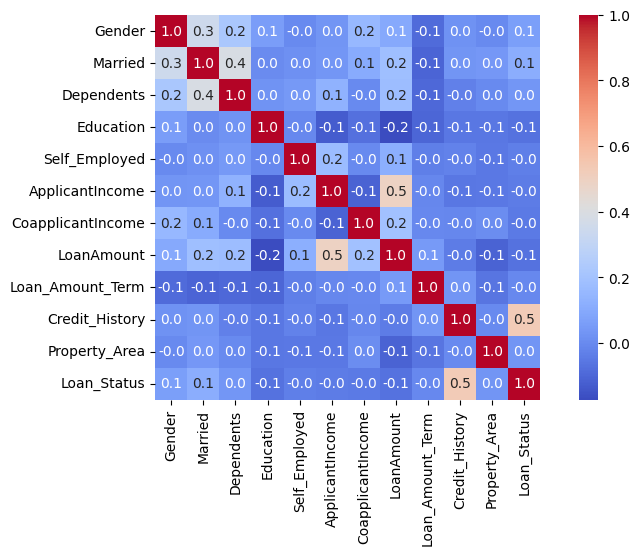

In [111]:
#Exploring correlation

corr_matrix = df.corr(numeric_only=True)
plt.figure(figsize=(10, 5))
sns.heatmap(corr_matrix, annot=True, square = True, fmt = '.1f', cmap='coolwarm')
plt.show()

# Model Training

In [112]:
def standardize(X):
  scaler = StandardScaler()
  return scaler.fit_transform(X)

In [113]:
#Separating features and label
X = df.drop(columns=['Loan_ID','Loan_Status'],axis=1).values
X = standardize(X)
Y = df['Loan_Status'].values

#Split data into training and test sets
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=2)

In [114]:
# Train a SVM model
model = svm.SVC(kernel='linear')
model.fit(X_train, Y_train)

SVC(kernel='linear')

In [115]:
# Evaluate the model
# Accuracy on training data
X_train_prediction = model.predict(X_train)
accuracy_score_training = accuracy_score(Y_train, X_train_prediction)

# Accuracy on test data
X_test_prediction = model.predict(X_test)
accuracy_score_test = accuracy_score(Y_test, X_test_prediction)

print('Accuracy on Training data:', accuracy_score_training)
print('Accuracy on Test data:', accuracy_score_test)

Accuracy on Training data: 0.8046875
Accuracy on Test data: 0.8229166666666666


In [116]:
def loan_status_check(input, true_label):
  #Reshape input
  input = input.reshape(1,-1)

  #Getting model to predict outcome based on input
  prediction = model.predict(input)

  if prediction[0] == 0:
    print('Prediction: Loan application to be rejected!')
  else:
    print('Prediction: Loan application to be accepted!')

  print(f"This loan application was originally: {'Rejected' if true_label == 0 else 'Accepted'}")

# Implementing Prediction System

In [117]:
for r in range(10):
  idx = np.random.randint(0, len(X_test))
  loan_status_check(X_test[idx], Y_test[idx])
  print("—" * 40)

Prediction: Loan application to be accepted!
This loan application was originally: Accepted
————————————————————————————————————————
Prediction: Loan application to be accepted!
This loan application was originally: Accepted
————————————————————————————————————————
Prediction: Loan application to be accepted!
This loan application was originally: Rejected
————————————————————————————————————————
Prediction: Loan application to be accepted!
This loan application was originally: Accepted
————————————————————————————————————————
Prediction: Loan application to be accepted!
This loan application was originally: Accepted
————————————————————————————————————————
Prediction: Loan application to be accepted!
This loan application was originally: Accepted
————————————————————————————————————————
Prediction: Loan application to be accepted!
This loan application was originally: Accepted
————————————————————————————————————————
Prediction: Loan application to be accepted!
This loan application wa